In [1]:
###Importing the modules###

import numpy as np
import xarray as xr
import math as mt
from datetime import datetime, timedelta
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from matplotlib import cm
from matplotlib.cm import get_cmap
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.patches as patches
import matplotlib.patheffects as path_effects
import glob
from metpy.plots import USCOUNTIES
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.feature import NaturalEarthFeature
import metpy.calc as mpcalc
from metpy.units import units
from scipy import stats
from collections import Counter
from scipy.ndimage import gaussian_filter
from scipy.stats import t
import matplotlib as mpl
import cftime

print("Done importing modules")

Done importing modules


In [2]:
###Import the datasets###

#Large Domain dfs#
MSLP_df = xr.open_dataset('/projects/zami4053/Synoptic_Research/Composite_NetCDFs/MSLP_anom_LD.nc')
OLR_df = xr.open_dataset('/projects/zami4053/Synoptic_Research/Composite_NetCDFs/OLR_anom_LD.nc')                      
PW_df = xr.open_dataset('/projects/zami4053/Synoptic_Research/Composite_NetCDFs/PW_anom_LD.nc')  
t850_df = xr.open_dataset('/projects/zami4053/Synoptic_Research/Composite_NetCDFs/t850_anom_LD.nc')
u250_df = xr.open_dataset('/projects/zami4053/Synoptic_Research/Composite_NetCDFs/u250_LD.nc')
v250_df = xr.open_dataset('/projects/zami4053/Synoptic_Research/Composite_NetCDFs/v250_LD.nc')
z250_df = xr.open_dataset('/projects/zami4053/Synoptic_Research/Composite_NetCDFs/z250_anom_LD.nc')
z250raw_df = xr.open_dataset('/projects/zami4053/Synoptic_Research/Composite_NetCDFs/z250raw_LD.nc')
z250raw_dfs = z250raw_df.sel(longitude=slice(200,280))

#Both Domain dfs# 
w500_df = xr.open_dataset('/projects/zami4053/Synoptic_Research/Composite_NetCDFs/w500_anom_LD.nc')
w850_df = xr.open_dataset('/projects/zami4053/Synoptic_Research/Composite_NetCDFs/w850_anom_LD.nc')
                                          
#Colorado Domain dfs#
sdews_df = xr.open_dataset('/projects/zami4053/Synoptic_Research/Composite_NetCDFs/sfcd_SD.nc')
sdews_raw_df = xr.open_dataset('/projects/zami4053/Synoptic_Research/Composite_NetCDFs/sfcDRaw_SD.nc')
stemps_raw_df = xr.open_dataset('/projects/zami4053/Synoptic_Research/Composite_NetCDFs/sfcTRaw_SD.nc')
stemp_df = xr.open_dataset('/projects/zami4053/Synoptic_Research/Composite_NetCDFs/sfct_SD.nc')
thetaE_df = xr.open_dataset('/projects/zami4053/Synoptic_Research/Composite_NetCDFs/thetaE_SD.nc')
u10_df = xr.open_dataset('/projects/zami4053/Synoptic_Research/Composite_NetCDFs/u10_SD.nc')
v10_df = xr.open_dataset('/projects/zami4053/Synoptic_Research/Composite_NetCDFs/v10_SD.nc')
PWSm_df = xr.open_dataset('/projects/zami4053/Synoptic_Research/Composite_NetCDFs/PWSm_SD.nc')
mslpraw_df = xr.open_dataset('/projects/zami4053/Synoptic_Research/Composite_NetCDFs/MSLPraw_SD.nc')


In [3]:
###Apply a guassian smoother on this var###

#Apply Gaussian filter to omega#
smoothed_w500_ds = w500_df.copy()  #Create a copy to store smoothed data
for var in w500_df.data_vars:
    smoothed_w500_ds[var] = xr.DataArray(gaussian_filter(w500_df[var], sigma=3), 
                                    dims=["latitude", "longitude"],
                                    coords={"latitude": w500_df.latitude, "longitude": w500_df.longitude})
    
smoothed_w500_ds

<xarray.Dataset>
Dimensions:          (latitude: 281, longitude: 721)
Coordinates:
  * latitude         (latitude) float32 80.0 79.75 79.5 ... 10.5 10.25 10.0
  * longitude        (longitude) float32 100.0 100.2 100.5 ... 279.5 279.8 280.0
Data variables:
    w500_anom_HP_l0  (latitude, longitude) float64 -0.05609 ... -0.04035
    w500_anom_HP_l1  (latitude, longitude) float64 -0.04835 ... -0.05526
    w500_anom_HP_l2  (latitude, longitude) float64 -0.0544 -0.05355 ... -0.06112
    w500_anom_HP_l3  (latitude, longitude) float64 -0.03947 ... -0.04929
    w500_anom_LP_l0  (latitude, longitude) float64 -0.06361 ... -0.05942
    w500_anom_LP_l1  (latitude, longitude) float64 -0.05481 ... -0.07238
    w500_anom_LP_l2  (latitude, longitude) float64 -0.02949 ... -0.07338
    w500_anom_LP_l3  (latitude, longitude) float64 -0.04503 ... -0.04984

In [4]:
###Calculate the total wind speed###

#Calculate wind speed#
wind_speed_HPl0 = np.sqrt(u250_df['u250_HP_l0']**2 + v250_df['v250_HP_l0']**2)
wind_speed_HPl0.shape

wind_speed_HPl1 = np.sqrt(u250_df['u250_HP_l1']**2 + v250_df['v250_HP_l1']**2)
wind_speed_HPl1.shape

wind_speed_LPl0 = np.sqrt(u250_df['u250_LP_l0']**2 + v250_df['v250_LP_l0']**2)
wind_speed_LPl0.shape

wind_speed_LPl1 = np.sqrt(u250_df['u250_LP_l1']**2 + v250_df['v250_LP_l1']**2)
wind_speed_LPl1.shape

(281, 721)

In [5]:
###Add the climo file back in to get the raw values for MSLP and 250z heights###

testing4 = xr.open_dataset('/pl/active/ATOC_SynopticMet/Michael/ERA5_Climos_LD/Climos_sl_LD_vars/climatology_LD_sl_1950-01-01 00:00:00.nc')
testing4

<xarray.Dataset>
Dimensions:    (latitude: 281, longitude: 721)
Coordinates:
    number     int64 ...
  * latitude   (latitude) float64 80.0 79.75 79.5 79.25 ... 10.5 10.25 10.0
  * longitude  (longitude) float64 100.0 100.2 100.5 100.8 ... 279.5 279.8 280.0
Data variables:
    msl        (latitude, longitude) float32 ...
    t2m        (latitude, longitude) float32 ...
    ttr        (latitude, longitude) float32 ...
    tcwv       (latitude, longitude) float32 ...

In [7]:
###Perform the statistical testing### 

#Import the datasets needed#
stemps_anom_stdv_df = xr.open_dataset('/projects/zami4053/Synoptic_Research/Composite_NetCDFs/sfcT_stdv_SD.nc')
z_anom_stdv_df = xr.open_dataset('/projects/zami4053/Synoptic_Research/Composite_NetCDFs/z250anom_stdv.nc')
PW_anom_stdv_df = xr.open_dataset('/projects/zami4053/Synoptic_Research/Composite_NetCDFs/PW_stdv.nc')

#Gather the mean maps of relevant vars again#
stemps_anom_mean_df = stemp_df.copy() 
z_anom_mean_df = z250_df.copy()
PW_anom_mean_df = PWSm_df.copy()

##Now lets do the t-test for every grid cell for the map##

#lons and lats#
lat, lon = PW_anom_mean_df.dims['latitude'], PW_anom_mean_df.dims['longitude']

#Chose a timelag and HP + LP#
var2sel_m_HP = PW_anom_mean_df['PWSm_HP_l2']
var2sel_st_HP = PW_anom_stdv_df['PW_stdv_HP_l2']  #HP group, can configure

var2sel_m_LP = PW_anom_mean_df['PWSm_LP_l2']
var2sel_st_LP = PW_anom_stdv_df['PW_stdv_LP_l2']   #LP group, can configure

#Extract mean and standard deviation#
mean1 = var2sel_m_HP.values 
std1 = var2sel_st_HP.values  #HP group

mean2 = var2sel_m_LP.values  
std2 = var2sel_st_LP.values  #LP group

#Sample sizes of LP and HP groups
n1, n2 = 145, 145 

#Empty arrays for t-statistics, p-values, and significance mask#
t_stats = np.zeros((lat, lon))
p_values = np.zeros((lat, lon))
significance_mask = np.zeros((lat, lon))

#Loop through each grid point and calculate the t-statistic and p-value#
for i in range(lat):
    for j in range(lon):
        
        #Calculate t-statistic#
        t_stats[i, j] = (mean1[i, j] - mean2[i, j]) / np.sqrt((std1[i, j]**2 / n1) + (std2[i, j]**2 / n2))
        
        #Calculate degrees of freedom#
        dof = ((std1[i, j]**2 / n1 + std2[i, j]**2 / n2)**2) / (
            ((std1[i, j]**2 / n1)**2 / (n1 - 1)) + ((std2[i, j]**2 / n2)**2 / (n2 - 1)))
        
        #Calculate two-sided p-value#
        p_values[i, j] = 2 * (1 - t.cdf(np.abs(t_stats[i, j]), dof))
        
        #Set mask: 1 for significant (p < 0.05), NaN otherwise#
        if p_values[i, j] < 0.01:
            significance_mask[i, j] = 1
            
        else:
            significance_mask[i, j] = np.nan

#Store all these vars#
#significance_mask_temps_l0 = significance_mask.copy()  #No need
#significance_mask_temps_l2 = significance_mask.copy()  #No need

#significance_mask_PW_l0 = significance_mask.copy()
significance_mask_PW_l2 = significance_mask.copy()
#significance_mask_z_l0 = significance_mask.copy()
#significance_mask_z_l1 = significance_mask.copy()

significance_mask_PW_l2

array([[nan, nan, nan, ...,  1.,  1.,  1.],
       [nan, nan, nan, ...,  1.,  1.,  1.],
       [nan, nan, nan, ...,  1.,  1.,  1.],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])

In [8]:
np.shape(significance_mask_PW_l2)

(33, 45)

/curc/sw/anaconda3/2020.11/envs/synoptic_f23/lib/python3.11/site-packages/cartopy/mpl/geoaxes.py:1655: UserWarning: The following kwargs were not used by contour: 'label'
  result = super().contourf(*args, **kwargs)
/curc/sw/anaconda3/2020.11/envs/synoptic_f23/lib/python3.11/site-packages/cartopy/mpl/geoaxes.py:1604: UserWarning: The following kwargs were not used by contour: 'linestyle'
  result = super().contour(*args, **kwargs)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


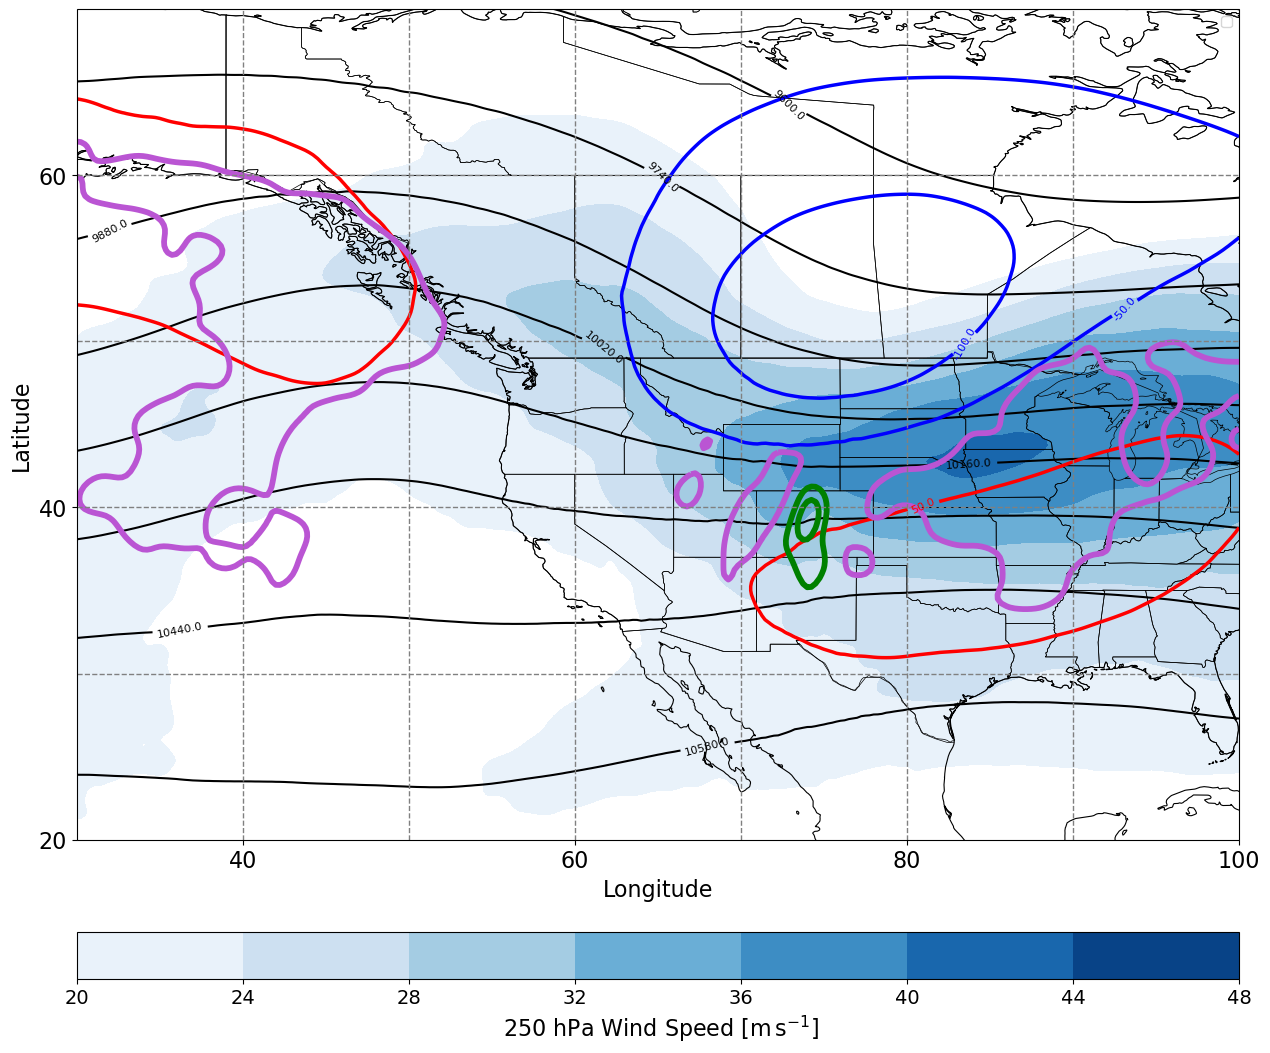

In [20]:
###Large Domain Composites HP###

#Set up the projection that will be used#
mapcrs = ccrs.LambertConformal(central_longitude=-55, central_latitude=45, standard_parallels=(33, 45)) 
mapcrs = ccrs.PlateCarree(central_longitude=180)

#Set up the projection of the data; if lat/lon then PlateCarree is what you want#
datacrs = ccrs.PlateCarree(central_longitude=180)

#Start the figure and create plot axes with proper projection#
fig = plt.figure(1, figsize=(15, 20)) 
ax = plt.subplot(111, projection=mapcrs) 
ax.set_extent([210, 280, 20, 70], ccrs.PlateCarree())  #-110, -100, 35, 43 
gl = ax.gridlines(crs=ccrs.PlateCarree(),linestyle="--", linewidth=1, color='grey', alpha=1)

#Add geopolitical boundaries for map reference#
ax.add_feature(cfeature.LAND, facecolor="white") 
countries = NaturalEarthFeature(category="cultural", scale="110m", facecolor="none", name="admin_0_boundary_lines_land") 
ax.add_feature(countries, linewidth=0.5, edgecolor="black") 
ax.add_feature(cfeature.STATES.with_scale('50m'), linewidth=0.5) 
ax.coastlines('50m', linewidth=0.8)

#Var and unit of interest to plot#
var_of_interest = '250 hPa Winds'
unit_of_interest = 'm/s'
time_lag= 0

#Extract the lons and lats#
lons = wind_speed_LPl0.longitude
lats = wind_speed_LPl0.latitude

#cbar_levels#
geop_levels = np.arange(9040, 10800, 140)
wind_speed_levels = np.arange(20, 50, 4)
#omega_levels = np.arange(-1.2, 1.3, 0.2)

#Add the fcontours#
ws250_cf = plt.contourf(lons, lats, wind_speed_LPl0, levels=wind_speed_levels, cmap="Blues", alpha=1, transform=ccrs.PlateCarree(), label="2-m Temp")
z250raw_c = plt.contour(z250raw_dfs['z250raw_LP_l0'].longitude, z250raw_dfs['z250raw_LP_l0'].latitude, z250raw_dfs['z250raw_LP_l0']/10, levels=geop_levels, linestyle='solid', colors="black", alpha=1, transform=ccrs.PlateCarree())
z250anom_c_pos = plt.contour(lons, lats, z250_df['z250_anom_LP_l0']/10, levels=[50,100, 150], linestyles='solid', linewidths=2.5, colors="red", alpha=1, transform=ccrs.PlateCarree())   #np.linspace(200, z250_df['z250_anom_HP_l0'].max(), 4)
z250anom_c_neg = plt.contour(lons, lats, z250_df['z250_anom_LP_l0']/10, levels=[-150, -100,-50], linestyles='solid', linewidths=2.5, colors="blue", alpha=1, transform=ccrs.PlateCarree())
w500_c_pos = plt.contour(lons, lats, smoothed_w500_ds['w500_anom_LP_l0'], levels=np.linspace(0.1, smoothed_w500_ds['w500_anom_LP_l1'].max(), 3), linestyles='solid', linewidths=4.15, colors="green", alpha=1, transform=ccrs.PlateCarree())
w500_c_neg = plt.contour(lons, lats, smoothed_w500_ds['w500_anom_LP_l0'], levels=np.linspace(smoothed_w500_ds['w500_anom_LP_l1'].min(), -0.1, 3), linestyles='solid', linewidths=4.15, colors="mediumorchid", alpha=1, transform=ccrs.PlateCarree())

#SS 99% contours
# masked_significance = np.where(
#     (z250_df['z250_anom_LP_l0'] / 10 > 50) | (z250_df['z250_anom_LP_l0'] / 10 < -50), 
#     significance_mask_z_l0, 
#     np.nan)

#z250_sig = plt.contourf(z_anom_mean_df.longitude, z_anom_mean_df.latitude, masked_significance, levels=None, hatches=['/'], colors='pink', alpha=0.0, transform=ccrs.PlateCarree())

#Add labels to the contours#
plt.clabel(z250anom_c_pos, inline=True, fontsize=8, fmt='%1.1f')
plt.clabel(z250anom_c_neg, inline=True, fontsize=8, fmt='%1.1f')
plt.clabel(z250raw_c, inline=True, fontsize=8, fmt='%1.1f')
#plt.clabel(w500_c_pos, inline=True, fontsize=8, fmt='%1.1f')
#plt.clabel(w500_c_neg, inline=True, fontsize=8, fmt='%1.1f')

#Colorbar and contour labels#
cbld = fig.colorbar(ws250_cf, orientation='horizontal', pad=0.06, extendrect=True, aspect=25, shrink=1)
cbld.set_label(r' 250 hPa Wind Speed [$\mathrm{m\,s^{-1}}$]', fontsize=16) 
cbld.ax.tick_params(labelsize=14) 

#Fix the lats and lon values#
#ax.set_xticks(range(-180, -70, 10), crs=ccrs.PlateCarree())
ax.set_yticks(range(20, 80, 20), crs=ccrs.PlateCarree())
ax.tick_params(axis='both', which='major', labelsize=16)
ax.set_xticks(range(220, 290, 20), crs=ccrs.PlateCarree())

plt.legend()

#Set labels for plot#
ax.set_xlabel('Longitude', fontsize=16)
ax.set_ylabel('Latitude', fontsize=16)
#plt.title(f'Composited 250 hPa winds [m/s], 250 hPa Heights & Anomalies [m], 500 hPa Omega [Pa/s]', fontsize=16) 

#plt.savefig("Comp_LD_LP0.png", dpi=150, bbox_inches='tight', pad_inches=0.1)

plt.show()

In [10]:
###Add a fgen calculation###

#vars to sub in#
data_sel_t = 'sfcTRaw_HP_l0'
data_sel_d = 'sfcDRaw_HP_l0'
data_sel_u = 'u10_HP_l0'
data_sel_v = 'v10_HP_l0'

#Lats and lons#
lats = stemp_df['sfct_LP_l0'].latitude.values
lons = stemp_df['sfct_LP_l0'].longitude.values
dx, dy = mpcalc.lat_lon_grid_deltas(lons, lats)

#Convert data to MetPy units#
#pressure_org = mslpraw_df['MSLPraw_HP_l0'].values * units.hPa
#pressure = pressure_org[:, :41]
temperature = stemps_raw_df[data_sel_t].values * units.degK   #Can also do K
dewpoint = sdews_raw_df[data_sel_d].values * units.degK
u_wind = u10_df[data_sel_u].values * units('m/s')
v_wind = v10_df[data_sel_v].values * units('m/s')
level = 850

#Convert temperature to potential temperature and equivalent potential temperature#
theta = mpcalc.potential_temperature(level * units.hPa, temperature)
theta_xr = xr.DataArray(theta, coords={'latitude': lats, 'longitude': lons}, dims=['latitude', 'longitude'])

thetaE = mpcalc.equivalent_potential_temperature(level * units.hPa, temperature, dewpoint)
thetaE_xr = xr.DataArray(thetaE, coords={'latitude': lats, 'longitude': lons}, dims=['latitude', 'longitude'])

#Calculate the frontogenesis#
frontogenesis_o = mpcalc.frontogenesis(theta_xr, u_wind, v_wind, dx=dx, dy=dy)
frontogenesis = frontogenesis_o * 1e9

frontogenesis_o2 = mpcalc.frontogenesis(thetaE_xr, u_wind, v_wind, dx=dx, dy=dy)
frontogenesis2 = frontogenesis_o2 * 1e9

#Smooth the fields since they are noisy#
frontogenesiss = mpcalc.smooth_gaussian(frontogenesis, 5)
frontogenesiss2 = mpcalc.smooth_gaussian(frontogenesis2, 5)

np.nanmin(frontogenesiss2), np.nanmax(frontogenesiss2)

(-6.956897137930523, 12.780409889301547)

In [13]:
###Apply smoothing###

#Smoothing#
temps = mpcalc.smooth_gaussian(stemp_df['sfct_HP_l0'], 10)
msl = mpcalc.smooth_gaussian(mslpraw_df['MSLPraw_HP_l0'], 10)

#Get the lon and lats#
lons_C = stemp_df['sfct_LP_l0'].longitude  #no touch
lats_C = stemp_df['sfct_LP_l0'].latitude   #no touch

#Get the sfc winds#
u = u10_df['u10_HP_l0'] * 1.944  #can config
v = v10_df['v10_HP_l0'] * 1.944  #can config

#Get the masked anomalies for PW#
masked_anomalies = np.ma.masked_where(np.isnan(significance_mask_PW_l2), PWSm_df['PWSm_HP_l0'])  #can change
masked_anomalies_big = np.ma.masked_inside(PWSm_df['PWSm_HP_l0'], -0.5, 0.5)


/curc/sw/anaconda3/2020.11/envs/synoptic_f23/lib/python3.11/site-packages/cartopy/mpl/geoaxes.py:1604: UserWarning: The following kwargs were not used by contour: 'label'
  result = super().contour(*args, **kwargs)
/curc/sw/anaconda3/2020.11/envs/synoptic_f23/lib/python3.11/site-packages/cartopy/mpl/geoaxes.py:1604: UserWarning: The following kwargs were not used by contour: 'label'
  result = super().contour(*args, **kwargs)
/curc/sw/anaconda3/2020.11/envs/synoptic_f23/lib/python3.11/site-packages/cartopy/mpl/geoaxes.py:1604: UserWarning: The following kwargs were not used by contour: 'linestyle', 'label'
  result = super().contour(*args, **kwargs)
/curc/sw/anaconda3/2020.11/envs/synoptic_f23/lib/python3.11/site-packages/cartopy/mpl/geoaxes.py:1604: UserWarning: The following kwargs were not used by contour: 'label'
  result = super().contour(*args, **kwargs)
/curc/sw/anaconda3/2020.11/envs/synoptic_f23/lib/python3.11/site-packages/cartopy/mpl/geoaxes.py:1655: UserWarning: The followi

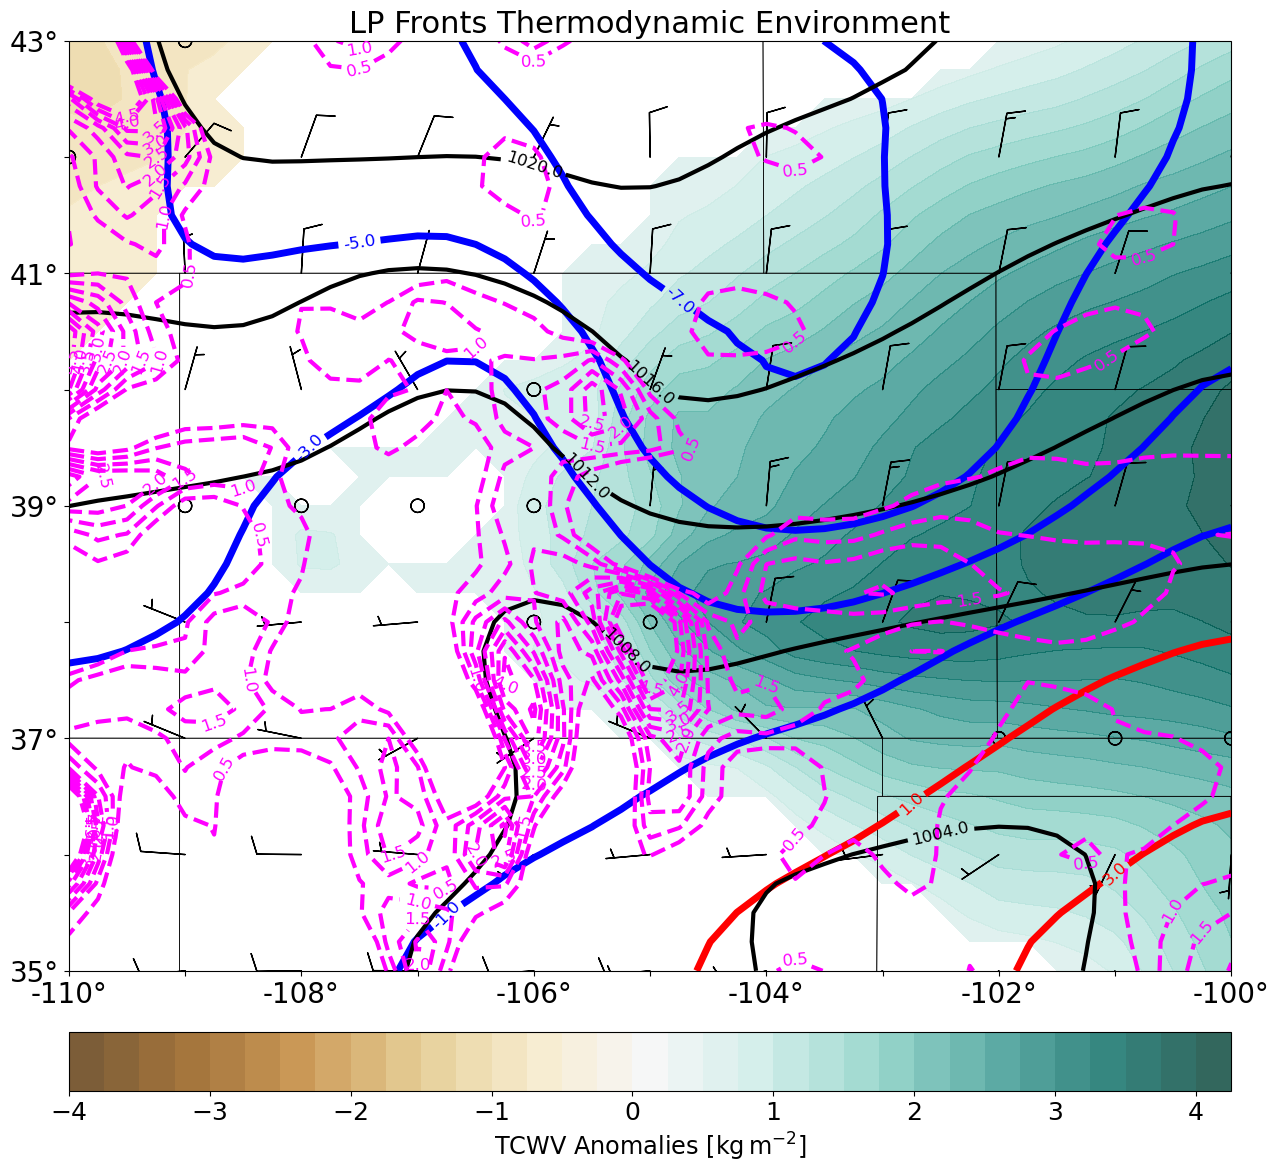

In [16]:
###Plot the composite map for Colorado Region###

#Specify a variable and units to plot#
var_of_interest = '2-m Temperature'
unit_of_interest = 'C'

#Set up the projection that will be used#
mapcrs = ccrs.LambertConformal(central_longitude=-55, central_latitude=45, standard_parallels=(33, 45)) 
mapcrs = ccrs.PlateCarree()

#Set up the projection of the data; if lat/lon then PlateCarree is what you want#
datacrs = ccrs.PlateCarree()

#Start the figure and create plot axes with proper projection#
fig = plt.figure(1, figsize=(15, 20)) 
ax = plt.subplot(111, projection=mapcrs) 
ax.set_extent([-110, -100, 35, 43], ccrs.PlateCarree())  #-110, -100, 35, 43 

#Add geopolitical boundaries for map reference#
ax.add_feature(cfeature.LAND, facecolor="white") 
countries = NaturalEarthFeature(category="cultural", scale="110m", facecolor="none", name="admin_0_boundary_lines_land") 
ax.add_feature(countries, linewidth=0.5, edgecolor="black") 
ax.add_feature(cfeature.STATES.with_scale('50m'), linewidth=0.5) 
ax.coastlines('50m', linewidth=0.8)

#Add the cbar levels#
mslp_levels = np.arange(1004, 1025, 4)
pw_levels = np.arange(-4, 4.5, 0.25)
mpl.rcParams['contour.negative_linestyle'] = 'dashed'

#Add the fcontours#
#PW_cf = plt.contourf(PWSm_df['PWSm_LP_l0'].longitude, PWSm_df['PWSm_LP_l0'].latitude, PWSm_df['PWSm_LP_l0'], levels=pw_levels, linestyle='solid', cmap="BrBG", alpha=1, transform=ccrs.PlateCarree(), label="2-m Temp")
stemp_cf_neg = plt.contour(lons_C, lats_C, temps, levels=np.arange(-11,0,2), colors="blue",linestyles=['solid'], linewidths=5, alpha=1, transform=ccrs.PlateCarree(), label="2-m Temp")
stemp_cf_pos = plt.contour(lons_C, lats_C, temps, levels=np.arange(1,11,2), linestyles=['solid'] * len(np.arange(1, 5, 2)), colors="red", linewidths=5, alpha=1, transform=ccrs.PlateCarree(), label="2-m Temp")
mslp_cf = plt.contour(mslpraw_df['MSLPraw_LP_l2'].longitude, mslpraw_df['MSLPraw_LP_l2'].latitude, msl/100, linewidths=3, levels=mslp_levels, linestyle='solid', colors="black", alpha=1, transform=ccrs.PlateCarree(), label="2-m Temp")
#fgen = plt.contour(lons_C, lats_C, frontogenesiss, levels=np.arange(1,5,0.5), linestyles=['dashed'], colors="brown", linewidths=4, alpha=1, transform=ccrs.PlateCarree(), label="2-m Temp")
fgen_E = plt.contour(lons_C, lats_C, frontogenesiss2, levels=np.arange(0.5,5,0.5), linestyles=['dashed'], colors="magenta", linewidths=3, alpha=1, transform=ccrs.PlateCarree(), label="2-m Temp")
#stemps_sig = plt.contourf(lons_C, lats_C, significance_mask_temps_l0, levels=None, colors="pink", alpha=0.8, transform=ccrs.PlateCarree(), label="2-m Temp")
#PW_sig = plt.contourf(PW_anom_mean_df.longitude, PW_anom_mean_df.latitude, significance_mask_PW_l0, levels=None, hatches=['/'], colors='pink', alpha=0.0, transform=ccrs.PlateCarree(), label="2-m Temp")

#SS 99% contours
PW_sig_mask = plt.contourf(PW_anom_mean_df.longitude, PW_anom_mean_df.latitude, masked_anomalies_big, levels=pw_levels, cmap="BrBG", alpha=0.8, transform=ccrs.PlateCarree(), label="2-m Temp")

#Plot the wind barbs every 5 grid cells#
skip = 4 

lon_skip = lons_C[::skip]
lat_skip = lats_C[::skip]
u_skip = u[::skip, ::skip]
v_skip = v[::skip, ::skip]

plt.barbs(lon_skip, lat_skip, u_skip, v_skip, length=8, transform=ccrs.PlateCarree())

#Colorbar and contour labels#
#cb = fig.colorbar(PW_cf, orientation='horizontal', pad=0.06, extendrect=True, aspect=20, shrink=1)
cb = fig.colorbar(PW_sig_mask, orientation='horizontal', pad=0.04, extendrect=True, aspect=20, shrink=1)
cb.set_label(r'TCWV Anomalies [$\mathrm{kg\,m^{-2}}$]', fontsize='xx-large')
plt.clabel(stemp_cf_neg, inline=True, fontsize=12, fmt='%1.1f')
plt.clabel(stemp_cf_pos, inline=True, fontsize=12, fmt='%1.1f')
plt.clabel(mslp_cf, inline=True, fontsize=12, fmt='%1.1f')
plt.clabel(fgen_E, inline=True, fontsize=12, fmt='%1.1f')
#plt.clabel(fgen_E, inline=True, fontsize=10, fmt='%1.1f')
cb.ax.tick_params(labelsize=18)

#Fix the lats and lon values#
ax.set_xticks(range(-110, -99, 1), crs=ccrs.PlateCarree())
ax.set_yticks(range(35, 44, 1), crs=ccrs.PlateCarree())
x_ticks = [-110,-108,-106,-104,-102,-100]
x_tick_labels = ['-110°','-108°','-106°','-104°','-102°','-100°']
y_ticks = [35,37,39,41,43]
y_tick_labels = ['35°','37°','39°','41°','43°']
plt.xticks(x_ticks, x_tick_labels)
plt.yticks(y_ticks, y_tick_labels)
ax.tick_params(axis='both', which='major', labelsize=20)

#Add a cross section vertical line#
# plt.axvline(x=-103, ymin=0.255, ymax=0.745, color='black', linewidth=6, linestyle='-')

# plt.text(-103.12, 36.75, "A", fontsize=28, color='black', verticalalignment='center', fontweight='bold')
# plt.text(-103.12, 41.25, "A'", fontsize=28, color='black', verticalalignment='center', fontweight='bold')

#Plot the longitude and latitude#
ax.set_xticks(range(-110, -99, 1), crs=ccrs.PlateCarree())
ax.set_yticks(range(35, 44, 1), crs=ccrs.PlateCarree())
#ax.set_xlabel('Longitude', fontsize=14)
#ax.set_ylabel('Latitude', fontsize=14)
plt.title(f'LP Fronts Thermodynamic Environment', fontsize=22) 

#plt.savefig("Comp_SD_LP0_REV.png", dpi=150, bbox_inches='tight', pad_inches=0.1)

plt.show()